In [1]:
# Packages
import math
import numpy as np
import matplotlib.pyplot as plt
import h5py
import netCDF4
from datetime import datetime
from matplotlib.colors import LogNorm
from glob import glob

In [2]:
# Functions
def Ne_convert(e: float,P: float,T: float) -> float:
    """Convert electron concentration to density

    Args:
        e (float): Mixing ration
        P (float): Pressure
        T (float): Temperature

    Returns:
        float: Electron density
    """
    return e*P/(k*T)

def z(p):
    """Convert pressure to altitude

    Args:
        p (float): pressure (in hPa)

    Returns:
        float: altitude (in km)
    """
    return - 7 * np.log(p/1013.25)

def convert_utime(start_time: float, end_time: float):
    """Convert numpy.float65 to datetime.datetime 

    Args:
        start_time (float): Start time of the measured data
        end_time (float): End time of the measured data

    Returns:
        datetime,datetime: Date converted to datetime
    """
    start_time2, end_time2 = [], []
    if len(start_time) == len(end_time):
        for i in range(len(start_time)):
            start_time2.append(datetime.fromtimestamp(data['utime'][0][i]))
            end_time2.append(datetime.fromtimestamp(data['utime'][1][i]))
        return np.array(start_time2), np.array(end_time2)
    
def get_nrec(metadata,data):
    """Get nrec value from searching in metadata

    Args:
        metadata ([[String]]): Metadata array
        data ([[String]]): Data array
    Returns:
        int: number of height measurements 
    """
    i = 0
    for array in metadata:
        if array[0].strip() == b'nrec':
            return(data[i][0])
        i += 1

In [161]:
# Files path, files opening and used constants
WACCM_path = '../DataRaw/unis*2004-12-08*.nc'
if len(glob(WACCM_path)) != 0:
    WACCM_file = netCDF4.Dataset(glob(WACCM_path)[0])
else:
    print('No WACCM data file found.')
    
EISCAT_path = '../DataRaw/EISCAT_2004-12-09*.hdf5'
if len(glob(EISCAT_path)) != 0:
    EISCAT_file = h5py.File(glob(EISCAT_path)[0])
else:
    print('No EISCAT data file found.')

k = 1.38*10**(-23) # J/K

In [162]:
# WACCM data
lat = WACCM_file['instr_lat'] # Latitude of the instrument
lon = WACCM_file['instr_lon'] # Longitude of the instrument
num = WACCM_file['instr_num'] # Numerical identifier of the instrument
date = WACCM_file['obs_date'] # Observation date
time = WACCM_file['obs_time'] # Observation time
lev = WACCM_file['lev'] # Pressure level
e = WACCM_file['e'] # Mixing ratio 
T = WACCM_file['T'] # Temperature

# Coordinate Restrictions for Tromso
mask_tromso = (lat[:] > 69.5) & (lat[:] < 69.7)
mask_svalbard = (lat[:] > 78.8) & (lat[:] < 79.0)


lev_mask = lev[:] < 0.01
P = lev[lev_mask]
H = z(P)
NeWACCM = []
for array in e[mask_svalbard]:
    NeWACCM.append(array[lev_mask])

NeWACCM = np.array(NeWACCM)
hours = time[mask_svalbard]/3600

mask_hours = [hours[i] > hours[i+1] for i in range(len(hours)-1)]
indices = [i+1 for i, value in enumerate(mask_hours) if value]

for indice in indices:
    hours[indice:] = hours[indice:] + 24

In [163]:
# EISCAT data
data = EISCAT_file['data'] # Get data from the file
metadata = EISCAT_file['metadata'] # Get metadata from the file

nrec = get_nrec(metadata['par0d'][:],data['par0d'][:]) # Number of height measurements 
h = data['par2d'][0] # Altitude m
Ne = data['par2d'][2] # Electron density m-3
Ti = data['par2d'][3] # Ion temperature K
Te = data['par2d'][4] # Electron to ion temperature ratio
ve = data['par2d'][6] # Electron drift velocity 
Time = np.repeat(data['utime'][0], nrec) # Time value

start_date, end_date = convert_utime(data['utime'][0],data['utime'][1]) # Converted time value
mask = h <= 150000 # Create mask for < 200 km
Timebis = np.repeat(start_date, nrec) 
Time_hours_minutes = np.array([float(t.strftime('%H.%M')) for t in Timebis]) # Converted time value in HH:MM
Date = start_date[0].strftime('%Y-%m-%d') # Converted time value in YYYY:mm:dd
date_EISCAT = start_date[0].strftime('%Y%m%d')

# Restricted values 
h = h[mask]/1000
Ne = Ne[mask]
Ti = Ti[mask]
Te = Te[mask]
Te = Ti*Te
ve = ve[mask]
Time = Time[mask]
Timebis = Timebis[mask]
Time_hours_minutes = Time_hours_minutes[mask]

for i in range(len(Time_hours_minutes)-1):
    if Time_hours_minutes[i+1] < Time_hours_minutes[i]:
        Time_hours_minutes[i+1] = Time_hours_minutes[i+1] + 24


i = 0
for i in range(len(Time_hours_minutes)):
    fractional_part, integer_part = math.modf(float(Time_hours_minutes[i]))
    Time_hours_minutes[i] = integer_part + int(fractional_part/0.6*100)/100
    if int(date_EISCAT[-4:-2])!= int(str(date[0])[-4:-2]):
        if int(str(date[0])[-4:-2]) in [1,3,5,7,8,10,12]:
            Time_hours_minutes[i] += 24 * (int(date_EISCAT[-2:]) + int(str(date[0])[-2:]) - 31)
        elif int(str(date[0])[-4:-2]) == 2:
            Time_hours_minutes[i] += 24 * (int(date_EISCAT[-2:]) + int(str(date[0])[-2:]) - 38)
        else:
            Time_hours_minutes[i] += 24 * (int(date_EISCAT[-2:]) + int(str(date[0])[-2:]) - 30)
    elif int(date_EISCAT) != int(date[0]):
        Time_hours_minutes[i] += 24 * (int(date_EISCAT) - int(date[0]))
    
n = len(Time_hours_minutes)

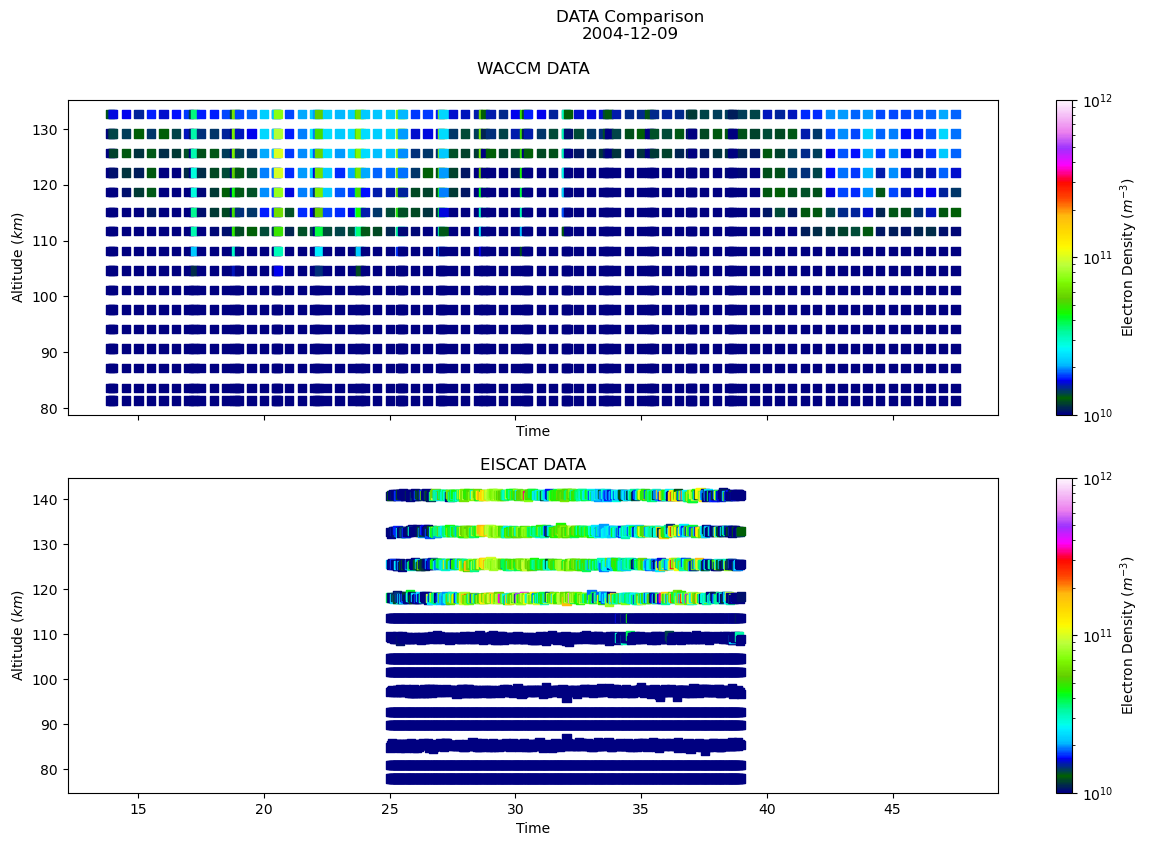

In [164]:
fig, axs = plt.subplots(2, sharex = True, figsize=(15, 9))

i = 0
for hour in hours:
    sc = axs[0].scatter(np.repeat(hour, len(H)), H, c = Ne_convert(NeWACCM[i],P*100,T[i][lev_mask]), cmap='gist_ncar', norm=LogNorm(vmin=10e9, vmax=10e11),marker = 's')
    i += 1
   
cbar = fig.colorbar(sc, ax=axs[0])
cbar.set_label(r'Electron Density ($m^{-3}$)')
axs[0].set_ylabel(r'Altitude ($km$)')
axs[0].set_xlabel(r'Time')
axs[0].set_title('WACCM DATA' + '\n' )

sc = axs[1].scatter(Time_hours_minutes, h, c = Ne, cmap='gist_ncar', norm=LogNorm(vmin=10e9, vmax=10e11),marker = 's')
cbar = fig.colorbar(sc, ax=axs[1])
cbar.set_label(r'Electron Density ($m^{-3}$)')
axs[1].set_ylabel(r'Altitude ($km$)')
axs[1].set_xlabel(r'Time')
axs[1].set_title('EISCAT DATA')
fig.suptitle('DATA Comparison' + '\n' + str(Date))
plt.show()

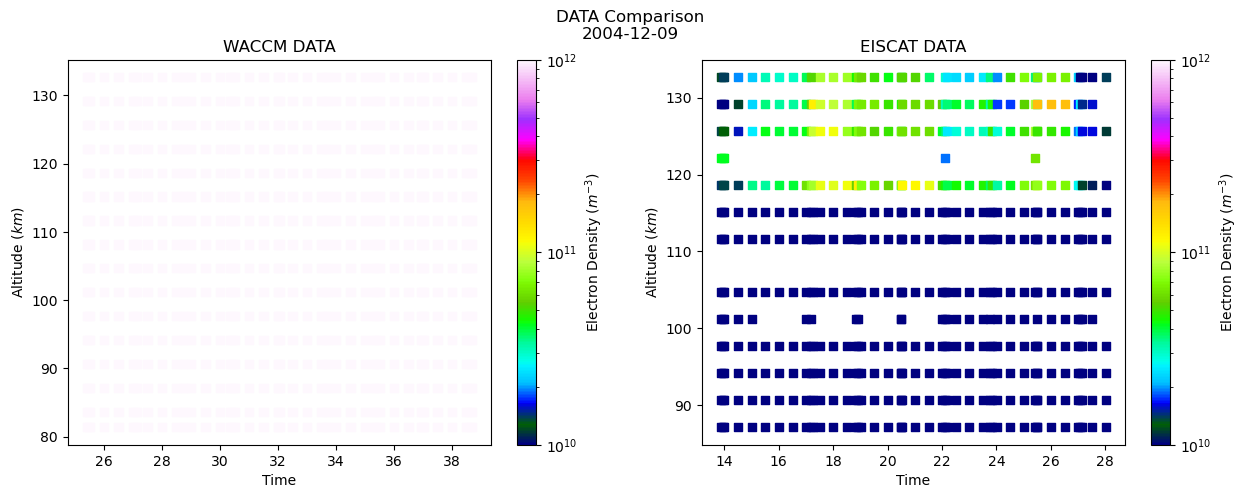

In [166]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

newHours = np.array([])

i = 0
while hours[i] < max(Time_hours_minutes):
    if hours[i] > min(Time_hours_minutes):
        sc = axs[0].scatter(np.repeat(hours[i], len(H)), H, c = Ne_convert(Ne[i],P*100,T[i][lev_mask]), cmap='gist_ncar', norm=LogNorm(vmin=10e9, vmax=10e11),marker = 's')
    i += 1

newHours = hours[:i]

i = 0
while newHours[i] < min(Time_hours_minutes):
    i += 1

newHours = newHours[i:]

cbar = fig.colorbar(sc, ax=axs[0])
cbar.set_label(r'Electron Density ($m^{-3}$)')
axs[0].set_ylabel(r'Altitude ($km$)')
axs[0].set_xlabel(r'Time')
axs[0].set_title('WACCM DATA')

i = 0
for i in range(len(newHours)):
    t_mask = (Time_hours_minutes > newHours[i]) & (Time_hours_minutes < newHours[i] + 0.5)
    if sum(t_mask) != 0:
        time1 = Time_hours_minutes[t_mask]
        Ne1 = Ne[t_mask]
        h1 = h[t_mask]
        for j in range(len(H)-1):
            h_mask = (h1 > H[j+1]) & (h1 < H[j]) 
            if sum(h_mask != 0):
                Ne2 = np.mean(Ne1[h_mask])
                axs[1].scatter(hours[i], H[j], c = Ne2, cmap='gist_ncar', norm=LogNorm(vmin=10e9, vmax=10e11),marker = 's')

                

cbar = fig.colorbar(sc, ax=axs[1])
cbar.set_label(r'Electron Density ($m^{-3}$)')
axs[1].set_ylabel(r'Altitude ($km$)')
axs[1].set_xlabel(r'Time')
axs[1].set_title('EISCAT DATA')
fig.suptitle('DATA Comparison' + '\n' + str(Date))
plt.show()